In [15]:
%pylab inline
# Allow inline Images. 
from IPython.display import Image 

import pandas
import numpy as np
# For Weighted Correlation
# http://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.DescrStatsW.html
from statsmodels.stats.weightstats import DescrStatsW

# Disable warnings
pandas.set_option('chained_assignment',None)

#Eurobarometer 30 (Oct-Nov 1988)
data = pandas.read_stata("ZA1715_v1-0-1.dta")

Table1_Data = data[['v5','v6','v7','v8','v9','v521','v520','v563','v565','v566','v567']]
Table1_Data.columns = [
    'Nation_1',                                                                 
    'Weight_1',                                                                 
    'Nation_2',                                                         
    'Weight_2',                                                                 
    'European_Weight',
    'membership',
    'unify',
    'Common_Defense',                                                           
    'Single_Currency',                                                          
    'Common_Foreign_Policy',                                                    
    'European_Government']





Populating the interactive namespace from numpy and matplotlib


In [16]:
# Functions.

def classify_membership(x):
    if x["membership"] == 'BAD THING':
        return 1
    if x["membership"] == 'NEITHER NOR':
        return 2
    if x["membership"] == 'GOOD THING':
        return 3

def classify_unify(x):
    if x["unify"] == 'AGAINST VERY MUCH':
        return 1
    if x["unify"] == 'AGAINST TO SOME EXT':
        return 2
    if x["unify"] == 'FOR TO SOME EXTENT':
        return 3
    if x["unify"] == 'FOR VERY MUCH':
        return 4
    else:
        # NaN coded as 'Don't Know'.
        return 2.5

def classify_Common_Defense(x):
    if x["Common_Defense"] == 'FOR':
        return 1
    if x["Common_Defense"] == 'AGAINST':
        return 0

def classify_Single_Currency(x):
    if x["Single_Currency"] == 'FOR':
        return 1
    if x["Single_Currency"] == 'AGAINST':
        return 0
    
def classify_Common_Foreign_Policy(x):
    if x["Common_Foreign_Policy"] == 'FOR':
        return 1
    if x["Common_Foreign_Policy"] == 'AGAINST':
        return 0

def classify_European_Government(x):
    if x["European_Government"] == 'FOR':
        return 1
    if x["European_Government"] == 'AGAINST':
        return 0

def policy_var(x):        
    policy_score = 0                                                            
    policies = [                  
        'Common_Defense',         
        'Single_Currency',                                                      
        'Common_Foreign_Policy',                                                
        'European_Government']                                                  
    for policy in policies:                                                     
        if x[policy] == 'FOR':                                                  
            policy_score += 1
    return policy_score


In [17]:
# Code All Data as used by section 1 of paper.

Table1_Data['Common_Defense_Numerical'] = Table1_Data.apply(classify_Common_Defense, axis=1)
Table1_Data['Single_Currency_Numerical'] = Table1_Data.apply(classify_Single_Currency, axis=1)
Table1_Data['Common_Foreign_Policy_Numerical'] = Table1_Data.apply(classify_Common_Foreign_Policy, axis=1)
Table1_Data['European_Government_Numerical'] = Table1_Data.apply(classify_European_Government, axis=1)
Table1_Data['mem_numerical'] = Table1_Data.apply(classify_membership, axis=1)
Table1_Data['unify_numerical'] = Table1_Data.apply(classify_unify, axis=1)
Table1_Data['Policy'] = Table1_Data.apply(policy_var, axis=1)


In [18]:
Table1_Data.columns

Index([u'Nation_1', u'Weight_1', u'Nation_2', u'Weight_2', u'European_Weight',
       u'membership', u'unify', u'Common_Defense', u'Single_Currency',
       u'Common_Foreign_Policy', u'European_Government',
       u'Common_Defense_Numerical', u'Single_Currency_Numerical',
       u'Common_Foreign_Policy_Numerical', u'European_Government_Numerical',
       u'mem_numerical', u'unify_numerical', u'Policy'],
      dtype='object')

In [19]:
c_list = [u'Common_Defense_Numerical',
          u'Common_Foreign_Policy_Numerical',
          u'Single_Currency_Numerical', 
          u'European_Government_Numerical', 
          u'Policy',
          u'Weight_1', 
          u'Weight_2', 
          u'European_Weight',
          u'mem_numerical', 
          u'unify_numerical']

coded_data = Table1_Data[c_list]
scribble_data = Table1_Data[c_list]

# Drop rows where answer was "don't know".
# This is probably wrong as it discads entire row even if only one answer is NaN.
coded_data = coded_data[pandas.notnull(coded_data['Common_Defense_Numerical'])]
coded_data = coded_data[pandas.notnull(coded_data['Common_Foreign_Policy_Numerical'])]
coded_data = coded_data[pandas.notnull(coded_data['Single_Currency_Numerical'])]
coded_data = coded_data[pandas.notnull(coded_data['European_Government_Numerical'])]

In [56]:
# What are the list of ratios we care about from question data:
# (We will return to policy var.)

# Create Ratio sets:
# Removing lines where either question isn't answered. 

CD_CFP = Table1_Data[
    [u'Common_Defense_Numerical',
        u'Common_Foreign_Policy_Numerical',
        u'European_Weight']]

for column in CD_CFP.columns:
    CD_CFP = CD_CFP[pandas.notnull(CD_CFP[column])]

CD_SC = Table1_Data[
    [u'Common_Defense_Numerical', u'Single_Currency_Numerical',
        u'European_Weight']]

for column in CD_SC.columns:
    CD_SC = CD_SC[pandas.notnull(CD_SC[column])]

CD_EG = Table1_Data[
    [u'Common_Defense_Numerical', u'European_Government_Numerical',
        u'European_Weight']]

for column in CD_EG.columns:
    CD_EG = CD_EG[pandas.notnull(CD_EG[column])]

CFP_SC = Table1_Data[
    [u'Common_Foreign_Policy_Numerical', u'Single_Currency_Numerical',
        u'European_Weight']]

for column in CFP_SC.columns:
    CFP_SC = CFP_SC[pandas.notnull(CFP_SC[column])]

CFP_EG = Table1_Data[
    [u'Common_Foreign_Policy_Numerical', u'European_Government_Numerical',
        u'European_Weight']]

for column in CFP_EG.columns:
    CFP_EG = CFP_EG[pandas.notnull(CFP_EG[column])]
    
SC_EG = Table1_Data[
    [u'Single_Currency_Numerical', u'European_Government_Numerical',
        u'European_Weight']]

for column in SC_EG.columns:
    SC_EG = SC_EG[pandas.notnull(SC_EG[column])]


In [61]:
d = SC_EG.drop('European_Weight', 1)
w = SC_EG['European_Weight']

print DescrStatsW(d, weights=w).corrcoef

[[ 1.          0.44670532]
 [ 0.44670532  1.        ]]


In [62]:
d = CFP_EG.drop('European_Weight', 1)
w = CFP_EG['European_Weight']

print DescrStatsW(d, weights=w).corrcoef

[[ 1.          0.43457333]
 [ 0.43457333  1.        ]]


In [20]:
d = coded_data[[u'Common_Defense_Numerical', u'Common_Foreign_Policy_Numerical',
       u'Single_Currency_Numerical', u'European_Government_Numerical',
       u'Policy']]

w = coded_data[[u'Weight_1', u'Weight_2', u'European_Weight']]

membership_unify_policy = coded_data[[u'Policy', u'mem_numerical', u'unify_numerical', u'Weight_1', u'Weight_2', u'European_Weight']]

print d.columns
# Weighted Correlation. (from statsmodule)
print DescrStatsW(d, weights=w.European_Weight).corrcoef

Index([u'Common_Defense_Numerical', u'Common_Foreign_Policy_Numerical',
       u'Single_Currency_Numerical', u'European_Government_Numerical',
       u'Policy'],
      dtype='object')
[[ 1.          0.27999832  0.23471525  0.33696122  0.6051867 ]
 [ 0.27999832  1.          0.41305368  0.44101172  0.74254282]
 [ 0.23471525  0.41305368  1.          0.46835921  0.75186784]
 [ 0.33696122  0.44101172  0.46835921  1.          0.78651709]
 [ 0.6051867   0.74254282  0.75186784  0.78651709  1.        ]]


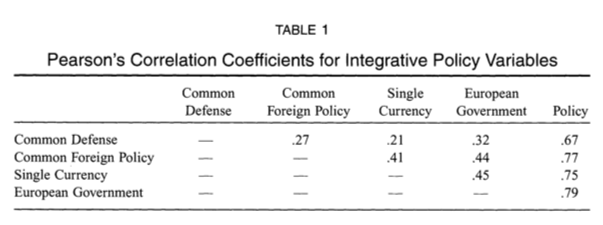

In [31]:
# Original Tale for Comparison.
Image(filename='papers/Table1.png')